<a href="https://colab.research.google.com/github/cladeira/Track/blob/master/BehaviouralCloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/cladeira/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [2]:
!ls Track


Drive2.py  Drive.py  driving_log.csv  IMG  model.h5


In [3]:
!pip3 install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa


Using TensorFlow backend.


In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1,0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle
  

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

In [0]:
datadir = 'Track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
#data.head()
#print (data)

In [11]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail 

data['center'] = data['center'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)

data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

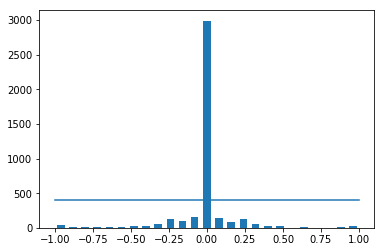

In [12]:
num_bins = 25
samples_per_bin = 400
  
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])), (samples_per_bin,samples_per_bin) )

Total Data 4053
removed: 2590
remaining: 1463


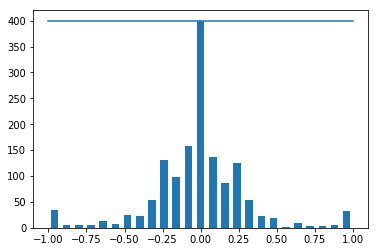

In [13]:
print("Total Data", len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, b = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])), (samples_per_bin,samples_per_bin) )


In [14]:
print (data.iloc[1])

center      center_2018_07_16_17_11_44_413.jpg
left        left_2018_07_16_17_11_44_413.jpg  
right       right_2018_07_16_17_11_44_413.jpg 
steering   -0.05                              
throttle    0.642727                          
reverse     0                                 
speed       1.43401                           
Name: 12, dtype: object


In [0]:
def load_img_steering(datadir, df):
  image_path =[]
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir +'/IMG', data)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6 )

In [17]:
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation Set')

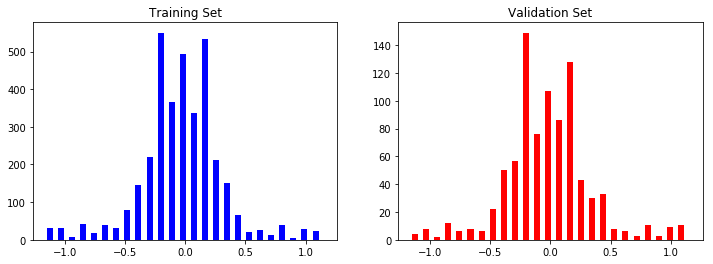

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue' )
axes[0].set_title('Training Set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red' )
axes[1].set_title('Validation Set')

In [0]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
panned_image = pan(original_image)
bright_image = img_random_brightness(original_image)
flipped_image, steering_angle_flip = img_random_flip(original_image, steering_angle)

Text(0.5, 1.0, 'Flipped Image -0.0')

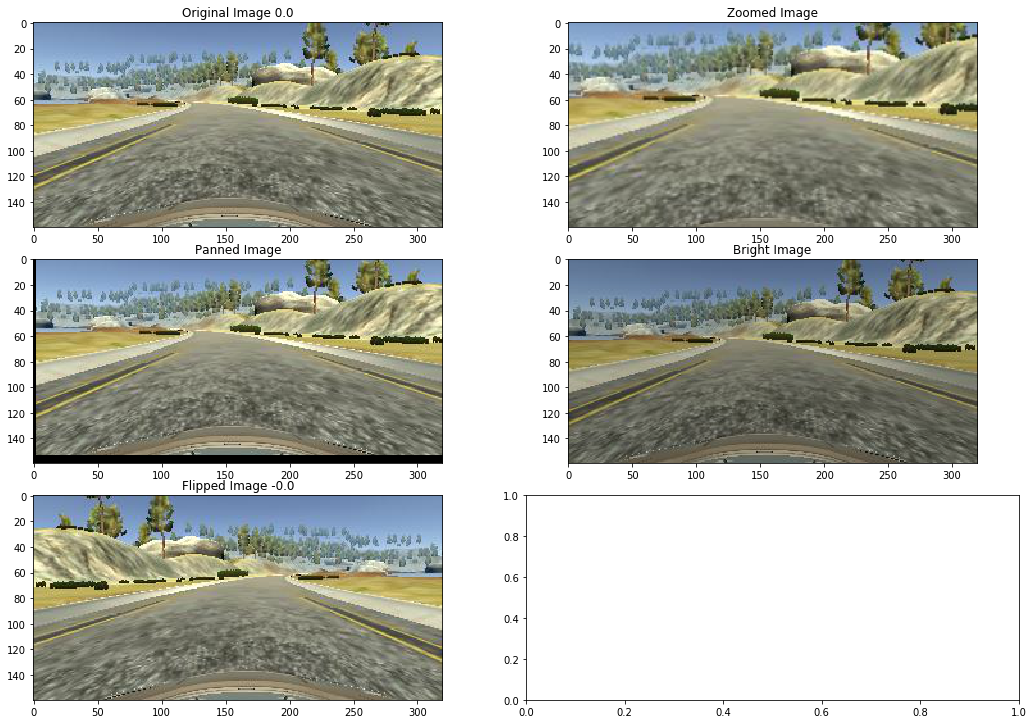

In [20]:
fig, axs = plt.subplots(3,2,figsize=(15,10))
fig.tight_layout()
axs[0,0].imshow(original_image)
axs[0,0].set_title('Original Image ' + str(steering_angle))

axs[0,1].imshow(zoomed_image)
axs[0,1].set_title('Zoomed Image')

axs[1,0].imshow(panned_image)
axs[1,0].set_title('Panned Image')

axs[1,1].imshow(bright_image)
axs[1,1].set_title('Bright Image')

axs[2,0].imshow(flipped_image)
axs[2,0].set_title('Flipped Image ' + str(steering_angle_flip))

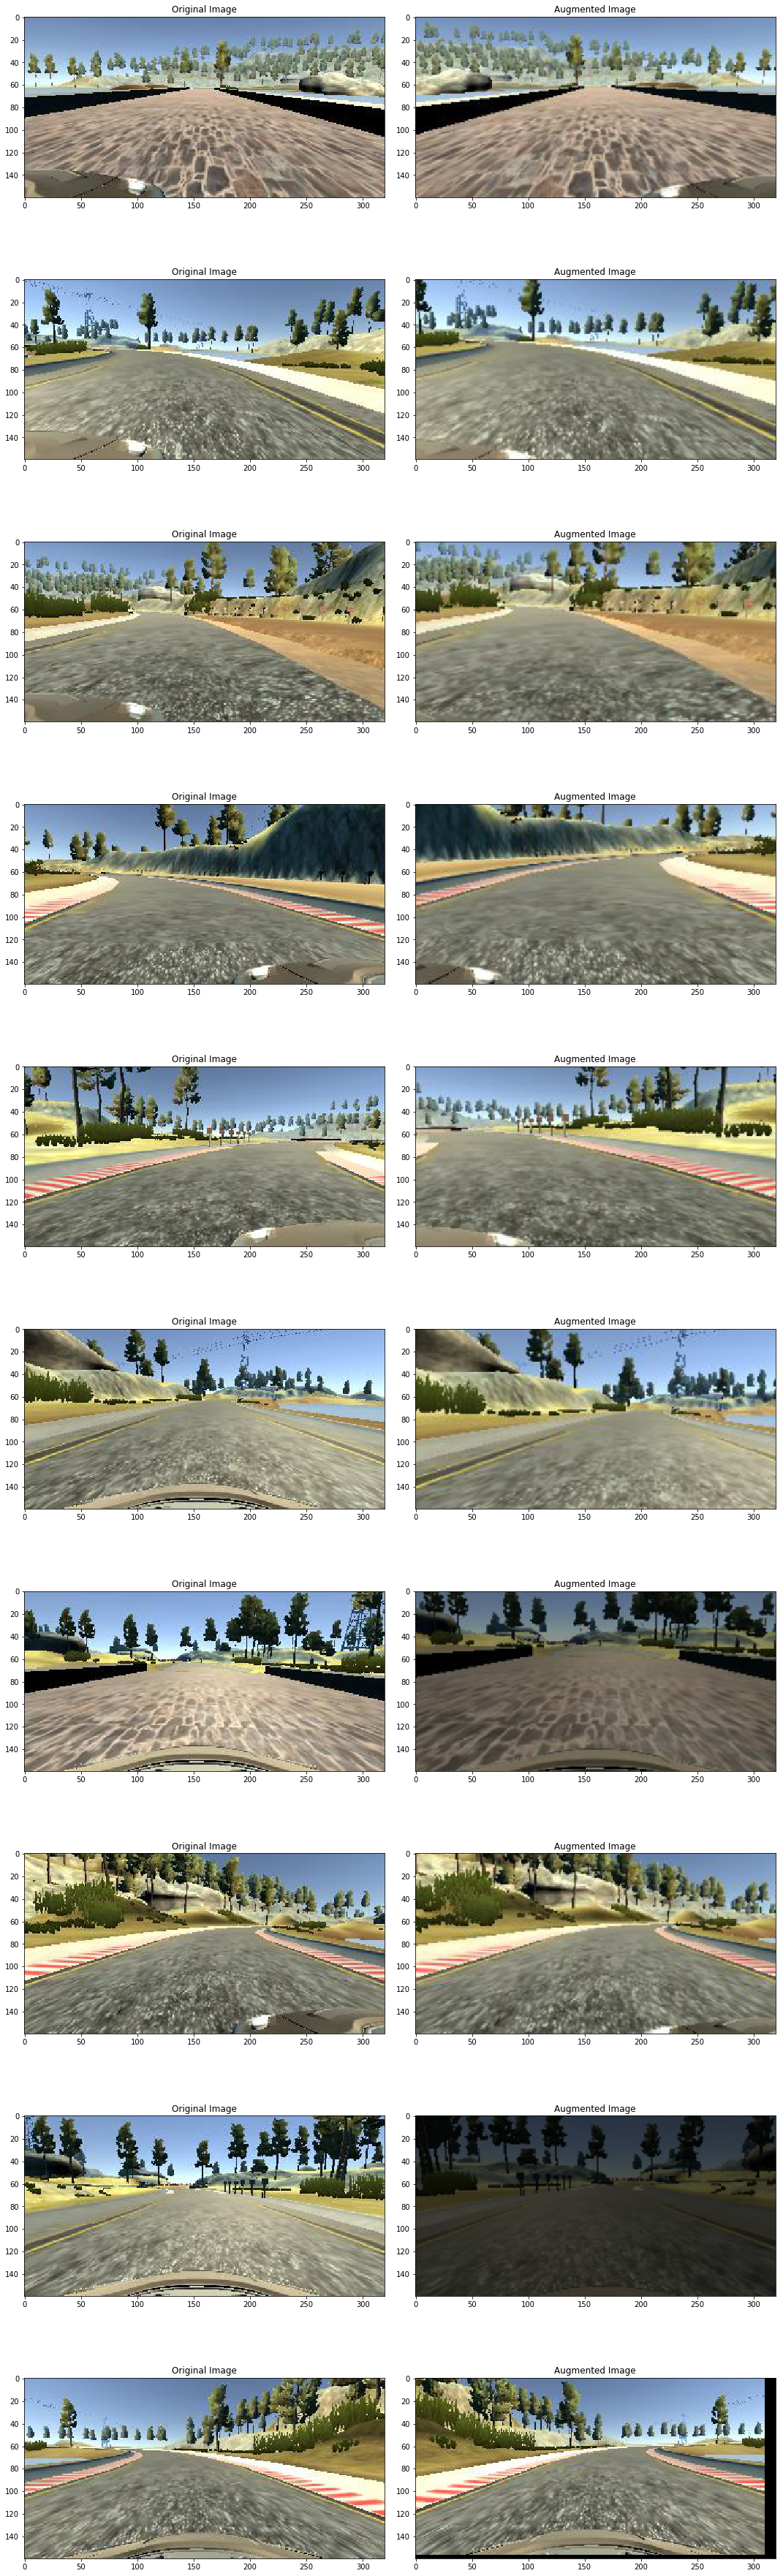

In [21]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()

for i in range(nrow):
    randnum = random.randint(0, len(image_paths)-1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title('Original Image')
    
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('Augmented Image')
    


Text(0.5, 1.0, 'Preprocessed Image')

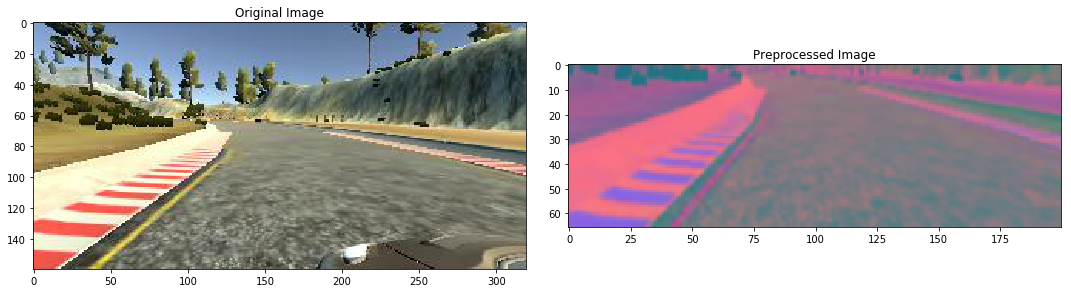

In [22]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img, (200, 66))
  #img = cv2.Canny(img,50,150)   
  img = img/255

  return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im) 
      batch_steering.append(steering)
      
    yield(np.asarray(batch_img), np.asarray(batch_steering))

In [0]:
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [0]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

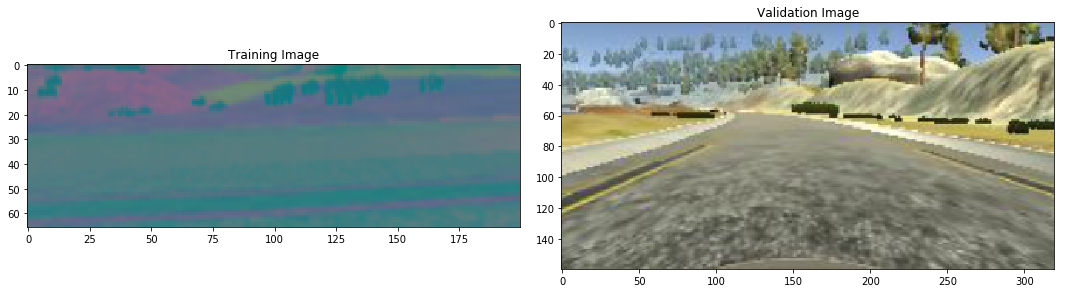

In [26]:
fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Validation Image')


In [0]:
def nvidia_model():
  
  model = Sequential()
  
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66, 200, 3), activation ='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation ='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation ='elu'))
  model.add(Convolution2D(64, 3, 3, activation ='elu'))
  model.add(Convolution2D(64, 3, 3, activation ='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(1, activation='elu'))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [28]:
model = nvidia_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [29]:
#history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, batch_size=100, verbose=1, shuffle=1)
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
300/300 [==============================] - 476s 2s/step - loss: 0.0835 - val_loss: 0.0653
Epoch 2/10
300/300 [==============================] - 469s 2s/step - loss: 0.0656 - val_loss: 0.0559
Epoch 3/10
300/300 [==============================] - 469s 2s/step - loss: 0.0599 - val_loss: 0.0519
Epoch 4/10
300/300 [==============================] - 469s 2s/step - loss: 0.0539 - val_loss: 0.0439
Epoch 5/10
300/300 [==============================] - 470s 2s/step - loss: 0.0502 - val_loss: 0.0385
Epoch 6/10
300/300 [==============================] - 468s 2s/step - loss: 0.0467 - val_loss: 0.0371
Epoch 7/10
300/300 [==============================] - 468s 2s/step - loss: 0.0442 - val_loss: 0.0324
Epoch 8/10
300/300 [==============================] - 469s 2s/step - loss: 0.0428 - val_loss: 0.0330
Epoch 9/10
300/300 [==============================] - 470s 2s/step - loss: 0.0415 - val_loss: 0.0313
Epoch 10/10
300/300 [======================

Text(0.5, 0, 'Epoch')

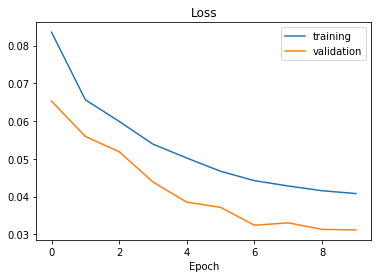

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')


In [0]:
model.save('model.h5')


In [0]:
from google.colab import files
files.download('model.h5')